# Causal Impact: Advanced Control Selection & Rationale

This notebook demonstrates a **Multi-Layer Robustness** framework for Causal Inference. We don't just pick cities that look like Barcelona; we put them through a statistical 'stress test' to ensure they are true behavioral twins.

## 1. The Rationale: Why standard correlation is dangerous
In time series, **Correlation != Connection**. Most business metrics share a 'General Trend' (e.g., inflation, seasonal growth). If you pick controls based on this trend, you fall into the **Spurious Correlation Trap**.

### Test 1: Stationarity & The 'Rainy Tuesday' (Behavioral Shocks)
*   **The Idea:** We strip away the trend (Differencing/Log) to see the **Daily Shocks**.
*   **Example:** Imagine **Sunglasses** and **Ice Cream**. In summer, both go up (High Raw Correlation). But if you have a random rainy Tuesday, the trend disappears. If both metrics drop *only* on that specific day, they are behaviorally synchronized.
*   **Why it matters:** This ensures the model reacts correctly to unexpected external events, preventing the prediction from 'drifting' away from reality.

### Test 2: Granger Causality (Predictive Information)
*   **The Idea:** We check if the control city's past actually helps us predict Barcelona's future.
*   **Example:** If City A is a 'leading indicator' (e.g., people there see the ads two days before Barcelona), it provides high-quality predictive intent to the model.
*   **Why it matters:** It identifies cities that are not just coincidental, but share a dynamic 'information flow' with our target.

### Test 3: Variance Ratio (Volatility Matching)
*   **The Idea:** We ensure the control has a similar 'swing' or noise level as Barcelona.
*   **Example:** Don't use a **small-town convenience store** (high daily volatility) to predict a **big-city flagship store** (stable volume), even if they follow the same trend. The noise from the small store will make the model's confidence intervals too wide.
*   **Why it matters:** This keeps the model's 'Standard Error' low, making it easier to prove a small +5% or +10% lift is statistically significant.

##  The Selection Hierarchy
1.  **PASS (All Tests):** Highly correlated, properly scaled, and carries predictive intent.
2.  **ELIGIBLE:** A strong behavioral match but lacks predictive leading-indicator status.
3.  **VOLATILE:** Matches behavior but is either too 'wiggly' or too 'flat' compared to Barcelona.
4.  **TIER 2:** A weaker match used only if no perfect twins exist (ensures the analysis can still run).

---

In [77]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from causalimpact import CausalImpact
import seaborn as sns


# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Set up
pre_beg, pre_end = '2023-01-01', '2023-05-31'
post_beg, post_end = '2023-06-01', '2023-06-30'
pre_period = [pre_beg, pre_end]
post_period = [post_beg, post_end]
target_col = 'Barcelona'

## 1. Load Data

In [78]:
df_long = pd.read_csv('sales_data.csv')
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Pivot the long format data back to wide format for analysis
df = df_long.pivot(index='Date', columns='City', values='Value')

print(f"Dataset loaded in LONG format and pivoted to WIDE. Total columns: {len(df.columns)}")
df.head()

df.index.freq = 'D'

Dataset loaded in LONG format and pivoted to WIDE. Total columns: 23


## 2. Refined Selection Step (Sequential Stationarity)

We evaluate each of the 20 cities. A city is selected if it has high correlation AND can be made stationary through our standard pipeline.

In [79]:
def get_stationary_transform(series, seasonal_period=7):
    """Returns (step_name, transform_func) or (None, None)."""
    def is_stationary(s):
        try:
            return adfuller(s.dropna())[1] < 0.05
        except:
            return False

    if is_stationary(series):
        return "Raw", lambda s: s
    
    try:
        s_log = np.log(series)
        if is_stationary(s_log): return "Log", lambda s: np.log(s)
        
        s_diff = s_log.diff()
        if is_stationary(s_diff): return "Log+Diff", lambda s: np.log(s).diff()
        
        s_seasonal = s_diff.diff(seasonal_period)
        if is_stationary(s_seasonal): 
            return "Log+Diff+Seasonal", lambda s: np.log(s).diff().diff(seasonal_period)
    except:
        pass
        
    return None, None

def select_best_controls(df_full, target, pre_beg, pre_end, t1_thresh=0.8, t2_thresh=0.6):
    df_pre = df_full.loc[pre_beg:pre_end]
    print(f"Selection tests applied to range: {df_pre.index.min()} to {df_pre.index.max()}")
    potential_controls = [c for c in df_full.columns if c != target]
    
    results = []
    for city in potential_controls:
        corr_raw = df_pre[target].corr(df_pre[city])
        step_name, transform_func = get_stationary_transform(df_pre[city])
        
        corr_trans = None
        granger_p = None
        var_ratio = None
        
        if step_name:
            s_city_trans = transform_func(df_pre[city]).dropna()
            s_target_trans = transform_func(df_pre[target]).dropna()
            
            # Behavioral Correlation
            joined = pd.concat([s_city_trans, s_target_trans], axis=1).dropna()
            corr_trans = joined.iloc[:, 0].corr(joined.iloc[:, 1])
            
            # Granger Causality
            try:
                granger_result = grangercausalitytests(joined[[target, city]], maxlag=2)
                granger_p = granger_result[1][0]['params_ftest'][1]
            except: granger_p = 1.0
            
            # Variance Ratio (Volatility Matching)
            var_ratio = s_city_trans.std() / s_target_trans.std()
        
        # Initial Assignment with Variance and Correlation Filter
        tier = "None"
        if corr_trans and corr_trans > t1_thresh:
            if 0.5 < var_ratio < 2.0:
                tier = "Tier 1 (Strict)"
            else:
                tier = "Rejected (High Variance)"
        elif corr_trans and corr_trans > t2_thresh and corr_raw > t2_thresh:
            tier = "Tier 2 (Fallback)"
        
        results.append({
            'City': city,
            'Correlation_Raw': corr_raw,
            'Correlation_Transformed': corr_trans,
            'Granger_p_value': granger_p,
            'Variance_Ratio': var_ratio,
            'Selection_Tier': tier
        })
    
    matrix = pd.DataFrame(results)
    
    # Final Selection Logic
    t1_cities = matrix[matrix['Selection_Tier'] == "Tier 1 (Strict)"]['City'].tolist()
    if t1_cities:
        selected = t1_cities
        status = f"Using Tier 1 (Strict) selection."
    else:
        t2_cities = matrix[matrix['Selection_Tier'] == "Tier 2 (Fallback)"]['City'].tolist()
        selected = t2_cities
        status = "No Tier 1 cities found. Falling back to Tier 2." if t2_cities else "No eligible cities found."
        
    return matrix, selected, status


selection_matrix, selected_cities, selection_status = select_best_controls(df, target_col, pre_beg, pre_end)

print(f"--- {selection_status} ---")
print(selection_matrix.sort_values('Correlation_Transformed', ascending=False))
print(f"\nFinal Selected Control Cities: {selected_cities}")

Selection tests applied to range: 2023-01-01 00:00:00 to 2023-05-31 00:00:00

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4839  , p=0.4878  , df_denom=146, df_num=1
ssr based chi2 test:   chi2=0.4938  , p=0.4822  , df=1
likelihood ratio test: chi2=0.4930  , p=0.4826  , df=1
parameter F test:         F=0.4839  , p=0.4878  , df_denom=146, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1538  , p=0.8576  , df_denom=143, df_num=2
ssr based chi2 test:   chi2=0.3184  , p=0.8528  , df=2
likelihood ratio test: chi2=0.3180  , p=0.8530  , df=2
parameter F test:         F=0.1538  , p=0.8576  , df_denom=143, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5947  , p=0.4418  , df_denom=147, df_num=1
ssr based chi2 test:   chi2=0.6069  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6056  , p=0.4364  , df=1
parameter F test:         F=0.5947  , p=0.4418  , df_denom=147, df_num=1

Granger Causalit

### Why we check Transformed Correlation

Look at **City_Spurious** in the matrix above:
- **Raw Correlation** is likely very high (> 0.9) because it shares the same trend/seasonality as Barcelona.
- **Transformed Correlation** is low because its daily 'shocks' are independent.

By enforcing **Tier 1 (Transformed > 0.8)**, we ensure that our controls are behaviorally synchronized, not just 'coincidentally growing' at the same rate. This prevents the model from relying on spurious relationships that could drift in the post-period.

## 3. Visualize Selection Results

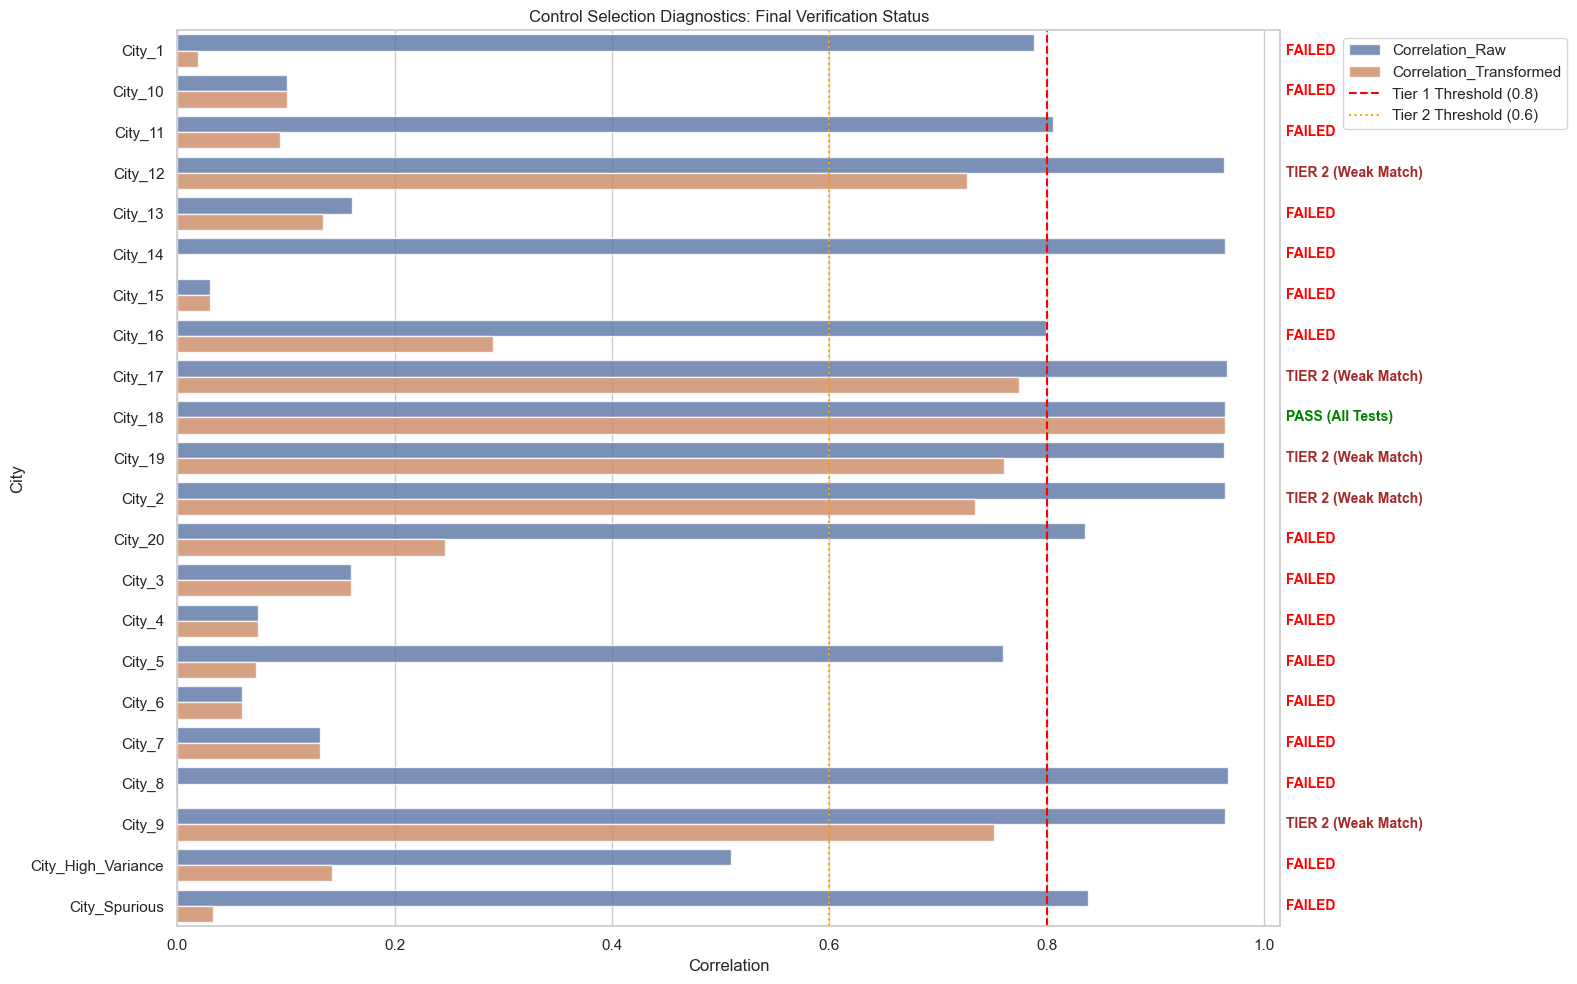

In [80]:
plt.figure(figsize=(16, 10))
comparison_df = selection_matrix.melt(id_vars=['City', 'Selection_Tier', 'Granger_p_value', 'Variance_Ratio'], 
                                       value_vars=['Correlation_Raw', 'Correlation_Transformed'],
                                       var_name='Type', value_name='Correlation')

sns.barplot(data=comparison_df, x='Correlation', y='City', hue='Type', alpha=0.8)
plt.axvline(0.8, color='red', linestyle='--', label='Tier 1 Threshold (0.8)')
plt.axvline(0.6, color='orange', linestyle=':', label='Tier 2 Threshold (0.6)')

for i, city in enumerate(selection_matrix['City']):
    row = selection_matrix.loc[selection_matrix['City'] == city].iloc[0]
    
    is_tier1 = row['Selection_Tier'] == "Tier 1 (Strict)"
    is_granger = row['Granger_p_value'] < 0.05
    is_var_ok = (0.5 < row['Variance_Ratio'] < 2.0) if row['Variance_Ratio'] is not None else False
    
    status_text = ""
    color = 'black'
    
    if is_tier1 and is_granger:
        status_text = "PASS (All Tests)"
        color = 'green'
    elif is_tier1:
        status_text = "ELIGIBLE (No Granger)"
        color = 'blue'
    elif row['Selection_Tier'] == "Rejected (High Variance)":
        status_text = "VOLATILE (Failed Var)"
        color = 'orange'
    elif row['Selection_Tier'] == "Tier 2 (Fallback)":
        status_text = "TIER 2 (Weak Match)"
        color = 'brown'
    else:
        status_text = "FAILED"
        color = 'red'
        
    plt.text(1.02, i, status_text, va='center', color=color, fontweight='bold', fontsize=10)

plt.title('Control Selection Diagnostics: Final Verification Status')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 4. Causal Impact Analysis

We use the original data for selected controls, knowing they are statistically robust.

['City_18']
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 89.61. By contrast, in the absence of an
intervention, we would have expected an average response of 69.73.
The 95% interval of this counterfactual prediction is [68.5, 71.04].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 19.88 with a 95% interval of
[18.58, 21.11]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2688.41.
By contrast, had the intervention not taken place, we would have expected
a sum of 2091.99. The 95% interval of this prediction is [2055.05, 2131.16].


The above results are given in terms of absolute numbers. In relative
terms, the 

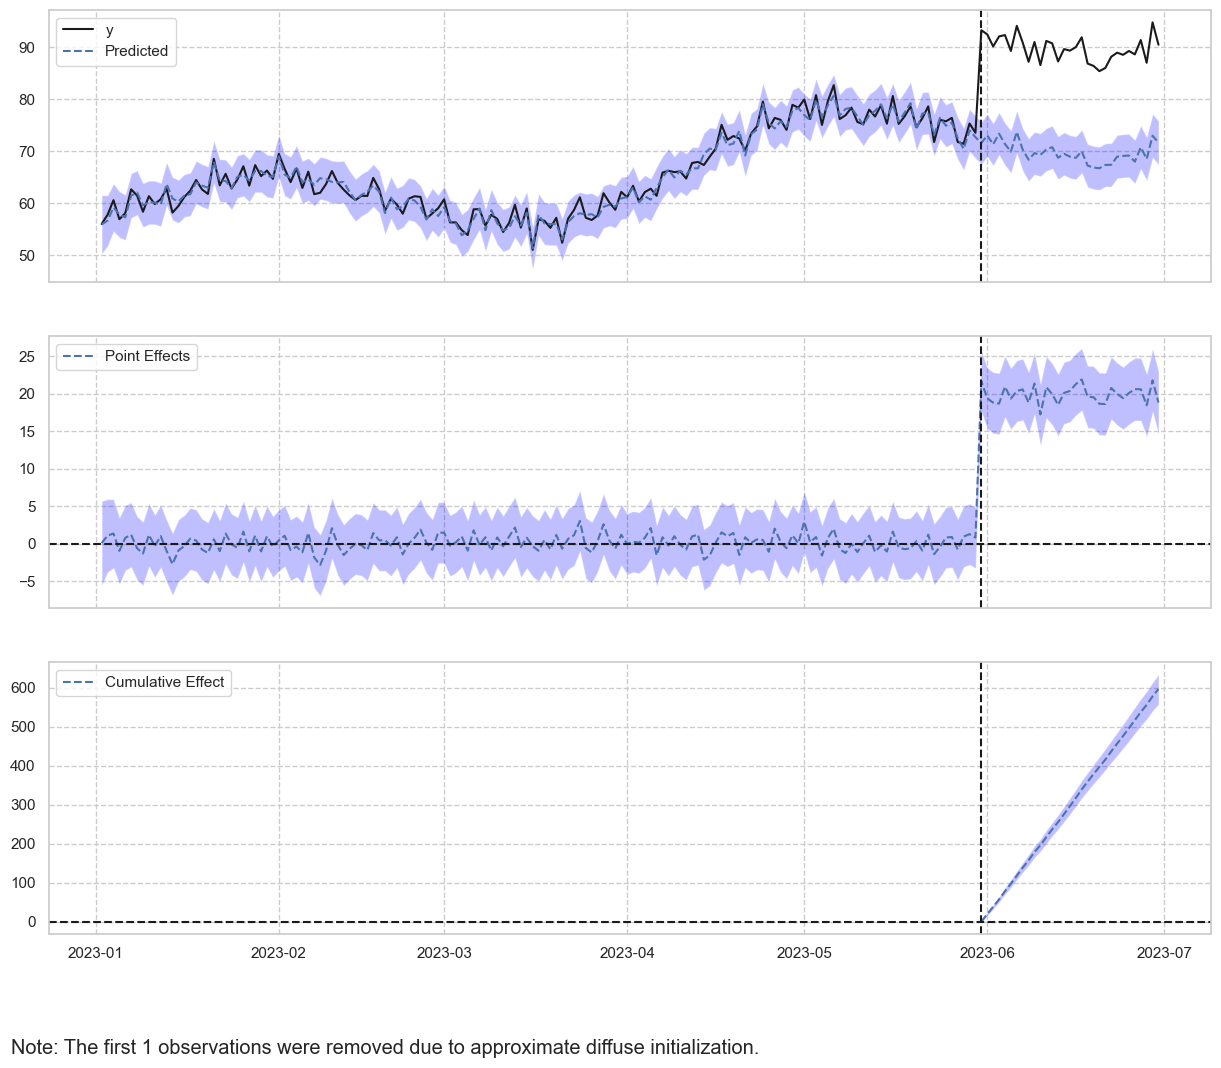

In [83]:
print(selected_cities)
if selected_cities:
    model_data = df[[target_col] + selected_cities]
    ci = CausalImpact(model_data, pre_period, post_period,)
    # print(ci.summary())
    print(ci.summary(output='report'))
    ci.plot()
else:
    print("ERROR: No cities met the strict selection criteria.")   